In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import tensorflow as tf
import numpy as np
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import json
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

SEED = 1234
tf.random.set_seed(SEED) 

curr_dir = os.getcwd()
dataset_dir = os.path.join(curr_dir,'MaskDataset')
training_dir = os.path.join(dataset_dir, 'training')
test_dir = os.path.join(dataset_dir, 'test')



In [3]:
# Batch size
bs = 12

# img shape 
img_h = 512
img_w = 512

num_classes=3

decide_class_indices = True
if decide_class_indices:
    classes = ['NO_PERSON',      # 0
               'ALL_THE_PEOPLE', # 1
               'SOMEONE']        # 2   

    
else:
    classes = None
    

In [4]:
# In case of necessity apply Data Augmentation

apply_data_augmentation = True
if apply_data_augmentation:
    train_data_gen = ImageDataGenerator(rotation_range=15,
                                        width_shift_range=20,
                                        height_shift_range=20,
                                        zoom_range=0.2,
                                        horizontal_flip=True,
                                        vertical_flip=False,
                                        fill_mode='constant',
                                        cval=0,
                                        rescale=1./255)
else:
    train_data_gen = ImageDataGenerator(rescale=1./255)
    
valid_data_gen = ImageDataGenerator(rescale=1./255)    
test_data_gen = ImageDataGenerator(rescale=1./255)



In [5]:
# Create a dataframe associating images to the corresponding labels, 
# then split it in two new dataframes, one for training and one for validation purposes

with open(os.path.join(dataset_dir,"train_gt.json")) as f:
    dic = json.load(f)
    df = pd.DataFrame(dic.items())
    df.rename(columns = {0:'filename', 1:'class'}, inplace = True)
    df["class"] = df["class"].astype(str)
    
    train_df, valid_df= train_test_split(df, shuffle = True , train_size = 0.8)
    
    

In [6]:
# Check statistics of valid and train to see if distribution is conserved
# top = most common value
# freq = the most common value’s frequency
# train_df.describe(include = 'all')

for i in range(3):
    prob_c_t = ((train_df[train_df['class'] == str(i)].shape[0])/train_df.shape[0])
    prob_c_v = ((valid_df[valid_df['class'] == str(i)].shape[0])/valid_df.shape[0])
    print('Probability of having class '+ str(i) + ' in training is %d', np.round( prob_c_t,3))
    print('Probability of having class '+ str(i)+ ' in validation is %d', np.round( prob_c_v,3))
    print('\n')


# We see the distribution is more or less the same


Probability of having class 0 in training is %d 0.337
Probability of having class 0 in validation is %d 0.345


Probability of having class 1 in training is %d 0.342
Probability of having class 1 in validation is %d 0.321


Probability of having class 2 in training is %d 0.321
Probability of having class 2 in validation is %d 0.335




In [7]:
train_gen = train_data_gen.flow_from_dataframe(train_df,
                                               training_dir,
                                               x_col="filename", 
                                               y_col="class",
                                               batch_size=bs,
                                               target_size=(img_h, img_w),
                                               color_mode='rgb',
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=SEED)

valid_gen = valid_data_gen.flow_from_dataframe(valid_df,
                                               training_dir,
                                               x_col="filename", 
                                               y_col="class",
                                               batch_size=bs,
                                               target_size=(img_h, img_w),
                                               color_mode='rgb',
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=SEED)

test_gen = test_data_gen.flow_from_directory(test_dir,
                                             batch_size=1, 
                                             classes=None,
                                             target_size=(img_h, img_w),
                                             color_mode='rgb',
                                             class_mode='categorical',
                                             shuffle=False,
                                             seed=SEED)


Found 4491 validated image filenames belonging to 3 classes.
Found 1123 validated image filenames belonging to 3 classes.
Found 450 images belonging to 1 classes.


In [8]:
# Create Dataset objects

train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, 3], [None, num_classes]))

train_dataset = train_dataset.repeat()


valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen, 
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, 3], [None, num_classes]))

valid_dataset = valid_dataset.repeat()


test_dataset = tf.data.Dataset.from_generator(lambda: test_gen,
                                              output_types=(tf.float32, tf.float32),
                                              output_shapes=([None, img_h, img_w, 3], [None, num_classes]))

test_dataset = valid_dataset.repeat()



[]

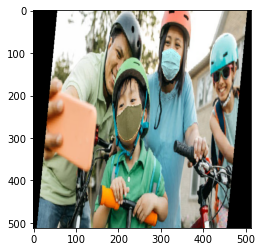

In [9]:
# Visualize the train_dataset

iterator = train_dataset.as_numpy_iterator()
augmented_img, target = next(iterator)

augmented_img = np.array(augmented_img[0])

augmanted_img = augmented_img * 255



plt.imshow(np.uint8(augmanted_img))

plt.plot()



### Build the Model

In [10]:
# Architecture: Features extraction -> Classifier

start_f = 40
depth = 8

model = tf.keras.Sequential()

# Features extraction
for i in range(depth):

    if i == 0:
        input_shape = [img_h, img_w, 3]
    else:
        input_shape=[None]

    # Conv block: Conv2D -> Activation -> Pooling
    model.add(tf.keras.layers.Conv2D(filters=start_f, 
                                     kernel_size=(3, 3),
                                     strides=(1, 1),
                                     padding='same',
                                     input_shape=input_shape))
    model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

    start_f *= 2
    
# Classifier
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=1024, activation='relu'))
model.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 512, 512, 40)      1120      
_________________________________________________________________
re_lu (ReLU)                 (None, 512, 512, 40)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 256, 256, 40)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 80)      28880     
_________________________________________________________________
re_lu_1 (ReLU)               (None, 256, 256, 80)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 80)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 160)     1

In [12]:
# Optimization params
# -------------------

# Loss
loss = tf.keras.losses.CategoricalCrossentropy()

# learning rate
lr = 1e-5
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Validation metrics
# ------------------

metrics = ['accuracy']
# ------------------

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)


In [ ]:
from datetime import datetime

cwd = 'D:'  # use your local directory if you are not using Drive

exps_dir = os.path.join(cwd, 'classification_experiments_')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

exp_name = 'FC' #fully connected

exp_dir = os.path.join(exps_dir, exp_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
#list of callback objects
callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

#create a checkpoint foreach epoch
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                   save_weights_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)

# ----------------

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)

# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, histogram_freq=1)  # if 1 shows weights histograms
callbacks.append(tb_callback)

# Early Stopping
# --------------
# monitor = quantity to be monitored (val_loss, val_accuracy)
# patiance = epochs to wait before stopping the training after overfitting is reached (tollerance) => possible improvement
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    callbacks.append(es_callback)
    
# ---------------------------------
#add the callbacks parameter and initialize it with the callbacks list created
model.fit(x=train_dataset,
          epochs=100,  #### set repeat in training dataset
          steps_per_epoch=len(train_gen),
          validation_data=valid_dataset,
          validation_steps=len(valid_gen), 
          callbacks=callbacks)

# How to visualize Tensorboard

# 1. tensorboard --logdir EXPERIMENTS_DIR --port PORT     <- from terminal
# 2. localhost:PORT   <- in your browser


Train for 375 steps, validate for 94 steps
Epoch 1/100
 51/375 [===>..........................] - ETA: 9:28 - loss: 1.1004 - accuracy: 0.3183

In [ ]:
def create_csv(results, results_dir='./'):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(key + ',' + str(value) + '\n')

In [ ]:

test_gen.reset()

predictions = model.predict(test_gen, verbose=1)

results = {}
images = test_gen.filenames
i = 0

import ntpath

for p in predictions:
    prediction = np.argmax(p)
    image_name = ntpath.basename(images[i])
    results[image_name] = str(prediction)
    i = i + 1


In [ ]:
create_csv(results, 'C:\\Users\\leona\\Downloads\\MaskDataset\\output') 